# Data Preparation - Viral Social Media Trends Analysis

In [194]:
# Imports
import json
import joblib
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Imports loaded")

Imports loaded


## Configurations

In [195]:
# Paths
RAW_DATA_PATH = "data/raw/Viral_Social_Media_Trends.csv"
PROCESSED_DIR = Path("data/processed")
ARTIFACTS_DIR = Path("artifacts")
FIGURES_DIR = Path("artifacts/figures")

# Create directories
for dir_path in [PROCESSED_DIR, ARTIFACTS_DIR, FIGURES_DIR]:
    dir_path.mkdir(parents=True, exist_ok=True)
    # Clear all files in directory
    for file in dir_path.glob('*'):
        if file.is_file():
            file.unlink()

# Constants
# TODO : Implement needed constraints

print("✅ Configuration loaded")


IQR_MULTIPLIER = 1.5

✅ Configuration loaded


## Helper Functions

In [196]:
def calculate_iqr_bounds(series, multiplier=1.5):
    """Calculate IQR-based outlier bounds"""
    q1, q3 = series.quantile([0.25, 0.75])
    iqr = q3 - q1
    return q1 - multiplier * iqr, q3 + multiplier * iqr

# TODO : Implement other Functions here 

def build_preprocessor(nominal_cols, ordinal_cols, ordinal_categories, numeric_cols):
    """Build preprocessing pipeline - Steps 6 & 7"""
    transformers = [
        ('num', Pipeline([
            ('scaler', StandardScaler())
        ]), numeric_cols),
        ('nom', Pipeline([
            ('onehot', OneHotEncoder(handle_unknown='ignore', min_frequency=0.01, sparse_output=False))
        ]), nominal_cols)
    ]
    
    if ordinal_cols:
        transformers.append(('ord', Pipeline([
            ('ordinal', OrdinalEncoder(categories=ordinal_categories, handle_unknown='use_encoded_value', unknown_value=-1))
        ]), ordinal_cols))
    
    return ColumnTransformer(transformers)

def extract_feature_names(fitted_ct):
    """Extract feature names from fitted ColumnTransformer"""
    names = []
    for name, transformer, columns in fitted_ct.transformers_:
        if name == 'num':
            names.extend(columns)
        elif name == 'nom':
            names.extend(transformer.named_steps['onehot'].get_feature_names_out(columns))
        elif name == 'ord':
            names.extend(columns)
    return names


def categorize_rate(er):
    if er < 1:
        return "Low"
    elif er < 5:
        return "Medium"
    else:
        return "High"

print("✅ Helper functions defined")





✅ Helper functions defined


## Load Raw Data

In [197]:
df_raw = pd.read_csv(RAW_DATA_PATH)
print(f"✅ Loaded {len(df_raw):,} rows, {len(df_raw.columns)} columns")

# Drop unnecessary text columns immediately
df_raw = df_raw.drop(columns=['Post_ID'], errors='ignore')
print(f"✅ Dropped host_name and name columns")

print(f"\nColumns: {list(df_raw.columns)}")
df_raw.head(3)


✅ Loaded 5,000 rows, 10 columns
✅ Dropped host_name and name columns

Columns: ['Platform', 'Hashtag', 'Content_Type', 'Region', 'Views', 'Likes', 'Shares', 'Comments', 'Engagement_Level']
✅ Dropped host_name and name columns

Columns: ['Platform', 'Hashtag', 'Content_Type', 'Region', 'Views', 'Likes', 'Shares', 'Comments', 'Engagement_Level']


,Platform,Hashtag,Content_Type,Region,Views,Likes,Shares,Comments,Engagement_Level
0,TikTok,#Challenge,Video,UK,4163464,339431,53135,19346,High
1,Instagram,#Education,Shorts,India,4155940,215240,65860,27239,Medium
2,Twitter,#Challenge,Video,Brazil,3666211,327143,39423,36223,Medium


MISSING VALUE ANALYSIS
Empty DataFrame
Columns: [Column, Missing_Count, Missing_Pct]
Index: []


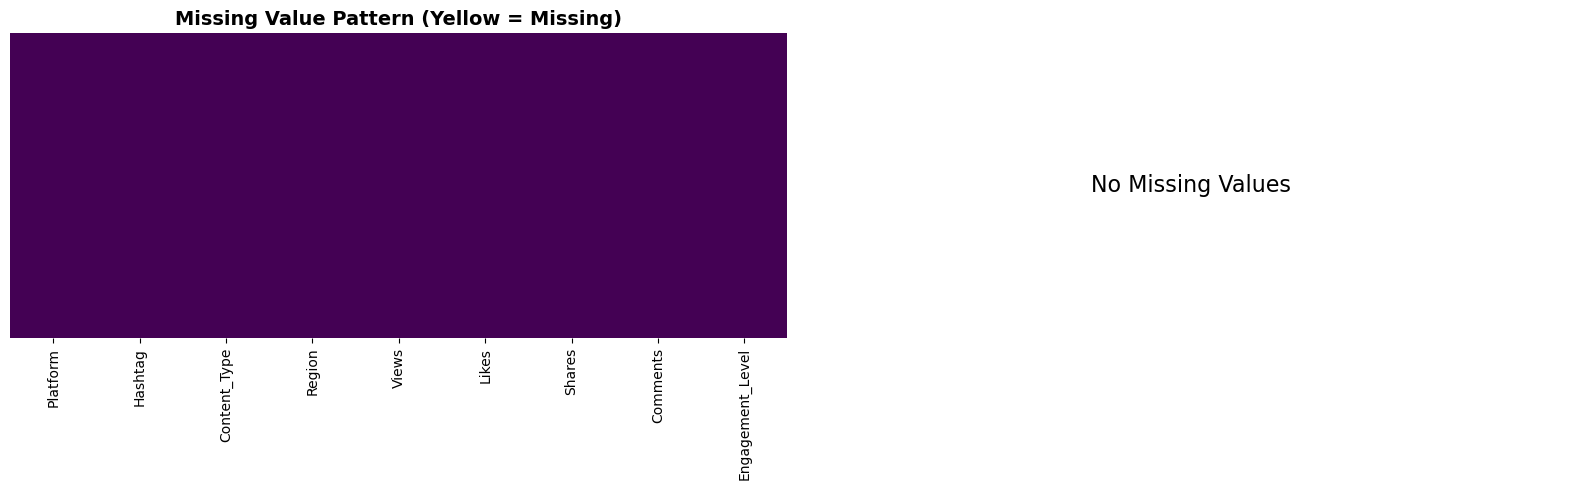


✅ Missing value analysis saved to artifacts\figures\missing_values_analysis.png

📝 Strategy: Impute after split (Step 3) using TRAIN statistics only


In [198]:
# Missing value statistics
missing = df_raw.isnull().sum()
missing_pct = (missing / len(df_raw) * 100).round(2)
missing_df = pd.DataFrame({
    'Column': missing.index,
    'Missing_Count': missing.values,
    'Missing_Pct': missing_pct.values
}).sort_values('Missing_Count', ascending=False)

print("=" * 80)
print("MISSING VALUE ANALYSIS")
print("=" * 80)
print(missing_df[missing_df['Missing_Count'] > 0].to_string(index=False))

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Heatmap
sns.heatmap(df_raw.isnull(), cbar=False, yticklabels=False, cmap='viridis', ax=ax1)
ax1.set_title('Missing Value Pattern (Yellow = Missing)', fontsize=14, fontweight='bold')

# Bar chart
missing_nonzero = missing_df[missing_df['Missing_Count'] > 0]
if len(missing_nonzero) > 0:
    ax2.barh(missing_nonzero['Column'], missing_nonzero['Missing_Pct'], color='coral', edgecolor='black')
    ax2.set_xlabel('Missing %', fontsize=12)
    ax2.set_title('Missing Value Percentage by Column', fontsize=14, fontweight='bold')
    ax2.invert_yaxis()
    for i, (col, pct) in enumerate(zip(missing_nonzero['Column'], missing_nonzero['Missing_Pct'])):
        ax2.text(pct + 0.5, i, f'{pct:.1f}%', va='center', fontsize=10)
else:
    ax2.text(0.5, 0.5, 'No Missing Values', ha='center', va='center', fontsize=16, transform=ax2.transAxes)
    ax2.axis('off')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'missing_values_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✅ Missing value analysis saved to {FIGURES_DIR / 'missing_values_analysis.png'}")
print(f"\n📝 Strategy: Impute after split (Step 3) using TRAIN statistics only")


## Exploratory Data Analysis

In [199]:
print("Data Summary:")
print(df_raw.describe())
print(f"\n✅ EDA complete - Ready for STEP 2: Split")

Data Summary:
              Views          Likes        Shares      Comments
count  5.000000e+03    5000.000000   5000.000000   5000.000000
mean   2.494066e+06  251475.029800  50519.562000  24888.393800
std    1.459490e+06  144349.583384  29066.362671  14284.504319
min    1.266000e+03     490.000000     52.000000     18.000000
25%    1.186207e+06  126892.250000  25029.000000  12305.250000
50%    2.497373e+06  249443.000000  50839.500000  25004.000000
75%    3.759781e+06  373970.750000  75774.250000  37072.750000
max    4.999430e+06  499922.000000  99978.000000  49993.000000

✅ EDA complete - Ready for STEP 2: Split


In [200]:
df_raw.describe()

,Views,Likes,Shares,Comments
count,5.000000e+03,5000.000000,5000.000000,5000.000000
mean,2.494066e+06,251475.029800,50519.562000,24888.393800
std,1.459490e+06,144349.583384,29066.362671,14284.504319
min,1.266000e+03,490.000000,52.000000,18.000000
25%,1.186207e+06,126892.250000,25029.000000,12305.250000
50%,2.497373e+06,249443.000000,50839.500000,25004.000000
75%,3.759781e+06,373970.750000,75774.250000,37072.750000
max,4.999430e+06,499922.000000,99978.000000,49993.000000


In [201]:
df_raw.describe(include='object')
for col in df_raw.select_dtypes(include='object').columns:
    print(f"\n{col}: {df_raw[col].nunique()} unique values")
    print(df_raw[col].unique())


Platform: 4 unique values
['TikTok' 'Instagram' 'Twitter' 'YouTube']

Hashtag: 10 unique values
['#Challenge' '#Education' '#Dance' '#Comedy' '#Gaming' '#Music' '#Viral'
 '#Fitness' '#Tech' '#Fashion']

Content_Type: 6 unique values
['Video' 'Shorts' 'Post' 'Tweet' 'Live Stream' 'Reel']

Region: 8 unique values
['UK' 'India' 'Brazil' 'Australia' 'Japan' 'Germany' 'Canada' 'USA']

Engagement_Level: 3 unique values
['High' 'Medium' 'Low']
['TikTok' 'Instagram' 'Twitter' 'YouTube']

Hashtag: 10 unique values
['#Challenge' '#Education' '#Dance' '#Comedy' '#Gaming' '#Music' '#Viral'
 '#Fitness' '#Tech' '#Fashion']

Content_Type: 6 unique values
['Video' 'Shorts' 'Post' 'Tweet' 'Live Stream' 'Reel']

Region: 8 unique values
['UK' 'India' 'Brazil' 'Australia' 'Japan' 'Germany' 'Canada' 'USA']

Engagement_Level: 3 unique values
['High' 'Medium' 'Low']


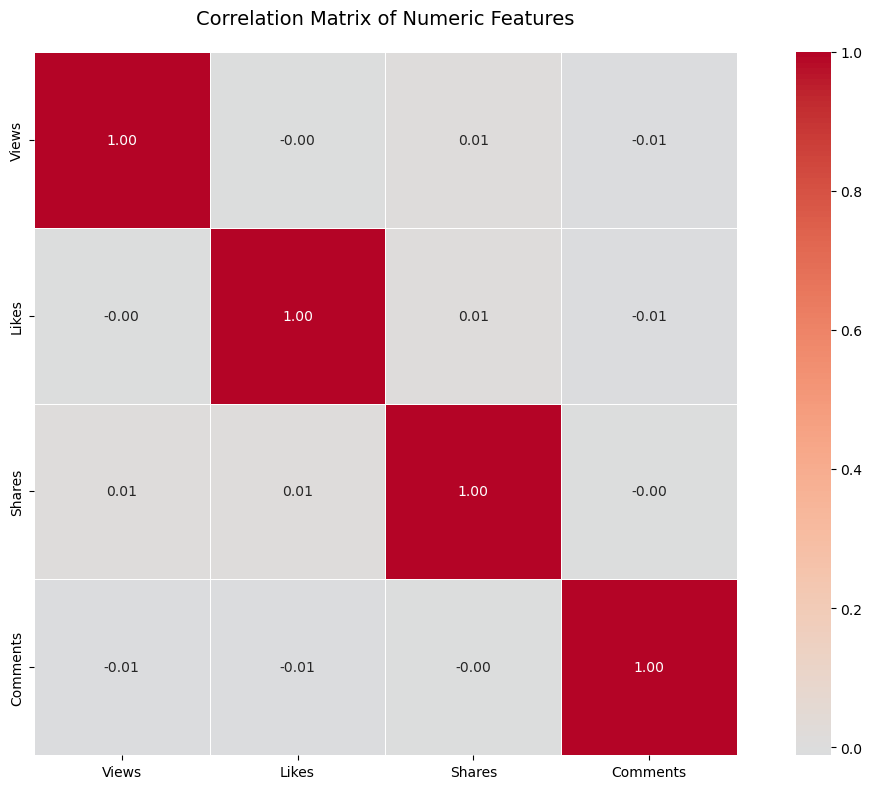


✅ Correlation analysis saved to artifacts\figures\correlation_matrix.png


In [202]:
# Plot correlation matrix
plt.figure(figsize=(12, 8))
numeric_cols = df_raw.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = df_raw[numeric_cols].corr()

# Create heatmap
sns.heatmap(
            correlation_matrix, 
            annot=True,
            cmap='coolwarm',
            center=0,
            fmt='.2f',
            square=True,
            linewidths=0.5
            )

plt.title('Correlation Matrix of Numeric Features', fontsize=14, pad=20)
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'correlation_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✅ Correlation analysis saved to {FIGURES_DIR / 'correlation_matrix.png'}")


## Data Visualization

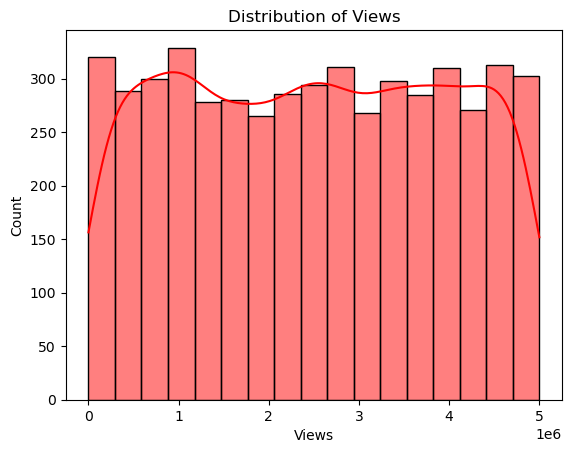

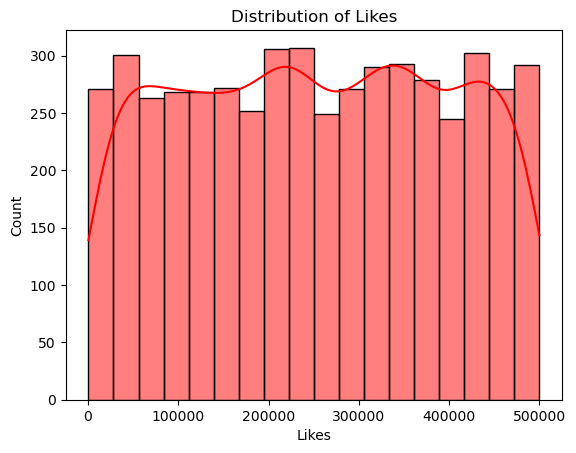

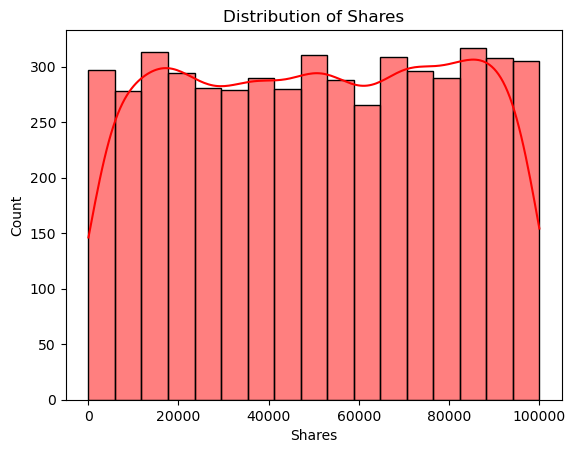

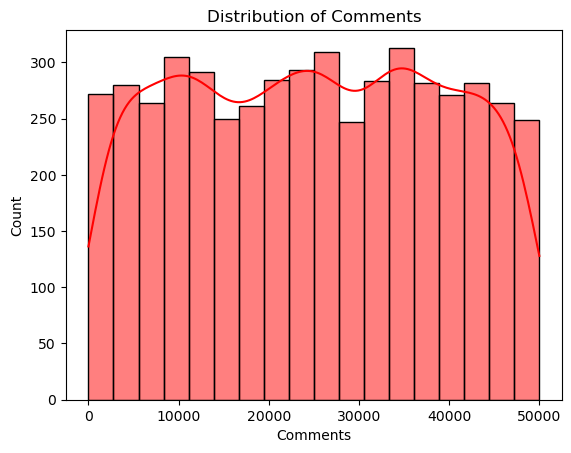

In [203]:
# Histograms for distribution
for i in df_raw.select_dtypes(include="number").columns:
    sns.histplot(data=df_raw, x=i, kde=True, color="red")
    plt.title(f'Distribution of {i}')
    plt.savefig(FIGURES_DIR / f'Histogram-distribution of {i}.png', dpi=150, bbox_inches='tight')
    plt.tight_layout
    plt.show()

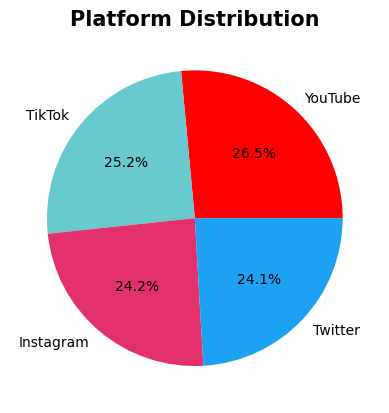

In [204]:
count = df_raw['Platform'].value_counts()
colors = ["#FF0000", "#69C9D0", "#E1306C", "#1DA1F2"]
plt.pie(count, labels=count.index, colors=colors ,autopct='%1.1f%%')
plt.title('Platform Distribution', fontsize=15 , weight='bold')
plt.savefig(FIGURES_DIR / f'PieChart.png', dpi=150, bbox_inches='tight')
plt.show()

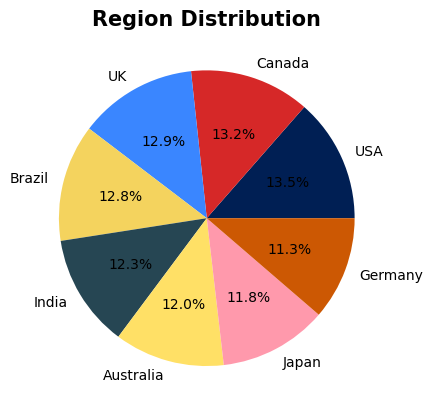

In [205]:
region_distribution = df_raw['Region'].value_counts()
colors = [ "#001f54" ,"#d62828","#3a86ff","#f4d35e","#264653","#ffe066","#ff99ac","#cc5803","#001f54" ,"#d62828" ]
plt.pie(region_distribution, labels=region_distribution.index, autopct='%1.1f%%', colors=colors)
plt.title('Region Distribution', fontsize=15 , weight='bold')
plt.savefig(FIGURES_DIR / f'Region Piechart.png', dpi=150, bbox_inches='tight')
plt.show()

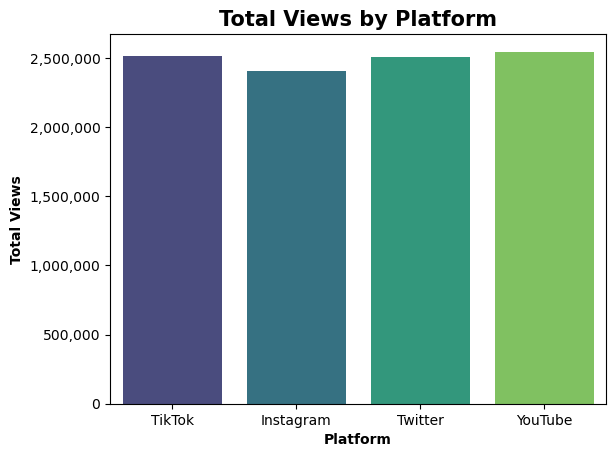

In [206]:
from matplotlib.ticker import FuncFormatter
sns.barplot(x='Platform', y='Views',data=df_raw, palette='viridis',ci=False)
plt.title('Total Views by Platform', fontsize=15 , weight='bold')
plt.xlabel('Platform', weight='bold')
plt.ylabel('Total Views', weight='bold')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.savefig(FIGURES_DIR / f'Barchart-Platform.png', dpi=150, bbox_inches='tight')
plt.show()

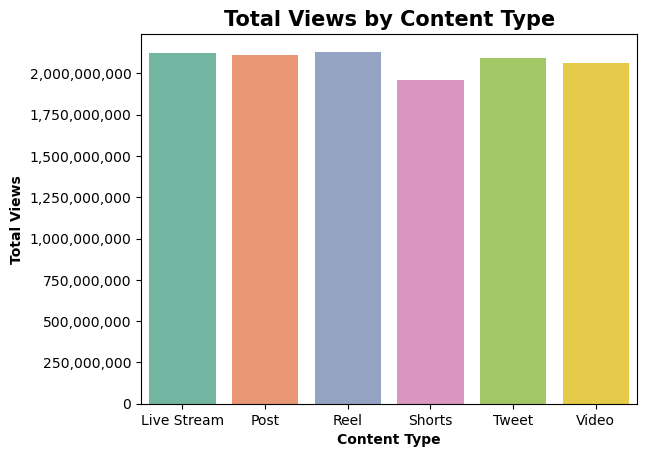

In [207]:
content_views = df_raw.groupby('Content_Type')['Views'].sum().reset_index()
sns.barplot(x='Content_Type', y='Views', data=content_views, palette='Set2')
plt.title('Total Views by Content Type', fontsize=15 , weight='bold')
plt.xlabel('Content Type', weight='bold')
plt.ylabel('Total Views', weight='bold')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.savefig(FIGURES_DIR / f'Barchart-ContentType.png', dpi=150, bbox_inches='tight')
plt.show()

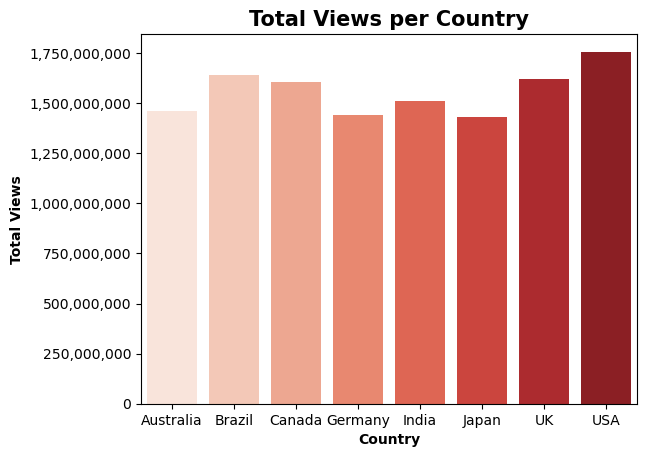

In [208]:
views_per_country = df_raw.groupby('Region')['Views'].sum()
sns.barplot(x=views_per_country.index, y=views_per_country.values , palette='Reds')
plt.title('Total Views per Country', fontsize=15 , weight='bold')
plt.xlabel('Country', weight='bold')
plt.ylabel('Total Views', weight='bold')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.savefig(FIGURES_DIR / f'Barchart-Country.png', dpi=150, bbox_inches='tight')
plt.show()

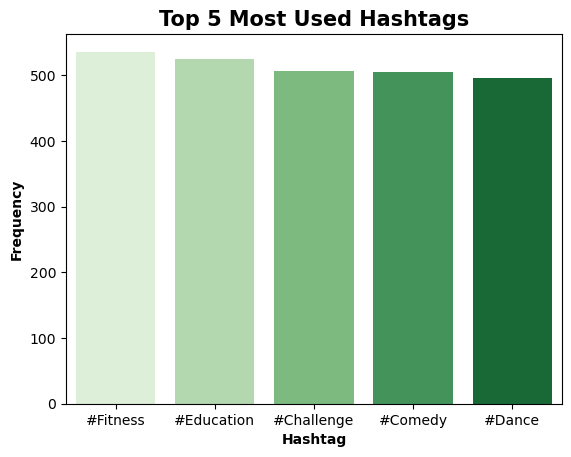

In [209]:
most5_used_hastags = df_raw['Hashtag'].value_counts().sort_values(ascending=False).nlargest(5)
sns.barplot(x=most5_used_hastags.index, y=most5_used_hastags.values, palette='Greens')
plt.title('Top 5 Most Used Hashtags', fontsize=15 , weight='bold')
plt.xlabel('Hashtag', weight='bold')
plt.ylabel('Frequency', weight='bold')
plt.savefig(FIGURES_DIR / f'Barchart-Hashtags.png', dpi=150, bbox_inches='tight')
plt.show()

## Split Train/Test 

#### Define feature columns

In [210]:
NOMINAL_COLS = ['Platform', 'Hashtag', 'Region', 'Content_Type']
ORDINAL_COLS = ['Engagement_Level']
ORDINAL_CATEGORIES = [['High', 'Medium', 'Low']]
NUMERIC_COLS = ['Views', 'Likes', 'Shares', 'Comments']


feature_cols = NOMINAL_COLS + ORDINAL_COLS +  NUMERIC_COLS
targets = NUMERIC_COLS
target_cal = ORDINAL_COLS

X = df_raw[feature_cols].copy()
y_reg = df_raw[targets].copy()
y_cal = df_raw[target_cal].copy()

X_train, X_test, y_train_reg, y_test_reg = train_test_split(
    X, y_reg, test_size=0.2, random_state=42
)

y_train_cal = y_cal.loc[y_train_reg.index]
y_test_cal = y_cal.loc[y_test_reg.index]

print(f"✅ Step 2 complete:")
print(f"   TRAIN: {len(X_train):,} samples")
print(f"   TEST:  {len(X_test):,} samples")
print(f"\n⚠️ NO FITTING HAS OCCURRED YET - ALL STATISTICS WILL USE TRAIN ONLY")

print(X_train)
print(X_test)

# TODO : Continue other Steps after this Split and do other


# Missing values are not present so there will be no missing value imputation

✅ Step 2 complete:
   TRAIN: 4,000 samples
   TEST:  1,000 samples

⚠️ NO FITTING HAS OCCURRED YET - ALL STATISTICS WILL USE TRAIN ONLY
       Platform     Hashtag     Region Content_Type Engagement_Level    Views  \
4227    Twitter      #Viral        USA        Tweet             High  1003601   
4676     TikTok     #Comedy  Australia       Shorts              Low  2366043   
800   Instagram      #Dance     Canada         Reel             High    34258   
3671    YouTube  #Education      Japan         Post             High   725454   
4193    YouTube    #Fashion        USA       Shorts             High   544588   
...         ...         ...        ...          ...              ...      ...   
4426    YouTube      #Viral    Germany         Reel           Medium  4983897   
466     Twitter    #Fitness  Australia        Tweet              Low  3684089   
3092     TikTok       #Tech  Australia         Post             High   921025   
3772    YouTube      #Dance  Australia        Video   

## Handle Outliers

In [211]:
train_outliers_total_reg = 0
test_outliers_total_reg = 0



for col in y_train_reg.columns:
    # Calculate bounds using training data only
    lower, upper = calculate_iqr_bounds(y_train_reg[col], IQR_MULTIPLIER)
    print(f"\n📊 {col}")
    print(f"IQR bounds (TRAIN): {lower:.2f} to {upper:.2f}")

    # Count outliers in train set
    train_outliers = ((y_train_reg[col] < lower) | (y_train_reg[col] > upper)).sum()
    train_outliers_total_reg += train_outliers

    # Count outliers in test set using same bounds
    test_outliers = ((y_test_reg[col] < lower) | (y_test_reg[col] > upper)).sum()
    test_outliers_total_reg += test_outliers

    print(f"Outliers detected in TRAIN={train_outliers:,}, TEST={test_outliers:,}")

print("\n✅ TOTAL OUTLIERS:")
print(f"TRAIN TOTAL = {train_outliers_total_reg:,}")
print(f"TEST TOTAL  = {test_outliers_total_reg:,}")

if train_outliers_total_reg == 0 and test_outliers_total_reg == 0:
    print("No outliers detected in any target variable. Skipping outlier removal.")

else:

    # Create combined masks
    mask_train_all = pd.Series(True, index=y_train_reg.index)
    mask_test_all = pd.Series(True, index=y_test_reg.index)

    # Remove Outliers
    for col in y_train_reg.columns:
        lower, upper = calculate_iqr_bounds(y_train_reg[col], IQR_MULTIPLIER)

        # if there are outliers present initialize the row to False
        mask_train_all &= (y_train_reg[col] >= lower) & (y_train_reg[col] <= upper)
        mask_test_all &= (y_test_reg[col] >= lower) & (y_test_reg[col] <= upper)

        # Apply masks (remove rows that are outliers in ANY target)
        X_train= X_train[mask_train_all]
        y_train_reg = y_train_reg[mask_train_all]

        X_test = X_test[mask_test_all]
        y_test_reg = y_test_reg[mask_test_all]

        print(f"✅ Outlier removal complete.")
        print(f"Remaining samples — TRAIN: {len(X_train)}, TEST: {len(X_test)}")

X_train
# test_outliers = ((y_test < price_lower) | (y_test > price_upper)).sum()
# print(f"Outliers detected: TRAIN={train_outliers:,}, TEST={test_outliers:,}")


📊 Views
IQR bounds (TRAIN): -2619189.00 to 7552085.00
Outliers detected in TRAIN=0, TEST=0

📊 Likes
IQR bounds (TRAIN): -245510.25 to 746031.75
Outliers detected in TRAIN=0, TEST=0

📊 Shares
IQR bounds (TRAIN): -50809.25 to 151706.75
Outliers detected in TRAIN=0, TEST=0

📊 Comments
IQR bounds (TRAIN): -24044.50 to 73531.50
Outliers detected in TRAIN=0, TEST=0

✅ TOTAL OUTLIERS:
TRAIN TOTAL = 0
TEST TOTAL  = 0
No outliers detected in any target variable. Skipping outlier removal.


,Platform,Hashtag,Region,Content_Type,Engagement_Level,Views,Likes,Shares,Comments
4227,Twitter,#Viral,USA,Tweet,High,1003601,488570,58252,33282
4676,TikTok,#Comedy,Australia,Shorts,Low,2366043,87673,4121,25516
800,Instagram,#Dance,Canada,Reel,High,34258,99120,37011,3149
3671,YouTube,#Education,Japan,Post,High,725454,149682,27039,47514
4193,YouTube,#Fashion,USA,Shorts,High,544588,266292,32491,20402
...,...,...,...,...,...,...,...,...,...
4426,YouTube,#Viral,Germany,Reel,Medium,4983897,256077,71883,39186
466,Twitter,#Fitness,Australia,Tweet,Low,3684089,213042,71881,21008
3092,TikTok,#Tech,Australia,Post,High,921025,77092,85563,8320
3772,YouTube,#Dance,Australia,Video,Low,2388341,286756,98722,44285


## Feature Engineering

In [212]:
df_raw['Engagement_Rate'] = (df_raw['Likes'] + df_raw['Comments'] + df_raw['Shares']) / df_raw['Views'].replace(0, np.nan)
df_raw['Engagement_Rate'] = df_raw['Engagement_Rate'].fillna(0)  # replace NaN from zero views


df_raw['Engagement_Level'] = df_raw['Engagement_Rate'].apply(categorize_rate)


df_raw['Engagement_Rate'] = df_raw['Engagement_Rate'] * 100


X_train

,Platform,Hashtag,Region,Content_Type,Engagement_Level,Views,Likes,Shares,Comments
4227,Twitter,#Viral,USA,Tweet,High,1003601,488570,58252,33282
4676,TikTok,#Comedy,Australia,Shorts,Low,2366043,87673,4121,25516
800,Instagram,#Dance,Canada,Reel,High,34258,99120,37011,3149
3671,YouTube,#Education,Japan,Post,High,725454,149682,27039,47514
4193,YouTube,#Fashion,USA,Shorts,High,544588,266292,32491,20402
...,...,...,...,...,...,...,...,...,...
4426,YouTube,#Viral,Germany,Reel,Medium,4983897,256077,71883,39186
466,Twitter,#Fitness,Australia,Tweet,Low,3684089,213042,71881,21008
3092,TikTok,#Tech,Australia,Post,High,921025,77092,85563,8320
3772,YouTube,#Dance,Australia,Video,Low,2388341,286756,98722,44285


## Scale and Encode

In [215]:
preprocessor = build_preprocessor(NOMINAL_COLS, ORDINAL_COLS, ORDINAL_CATEGORIES, NUMERIC_COLS)

print("Fitting preprocessor on TRAIN...")
preprocessor.fit(X_train)


X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)


print(f"\n✅ Steps 6 & 7 complete:")
print(f"   TRAIN shape: {X_train_transformed.shape}")
print(f"   TEST shape:  {X_test_transformed.shape}")

feature_names = extract_feature_names(preprocessor)
print(f"   Features: {len(feature_names)}")


# Save
joblib.dump(preprocessor, ARTIFACTS_DIR / 'preprocessor.joblib')
with open(ARTIFACTS_DIR / 'feature_names.json', 'w') as f:
    json.dump(feature_names, f, indent=2)

# Encode classification targets using Pandas categorical accessor

y_train_cat = y_train_cal['Engagement_Level'].astype('category')
y_train_cat = y_train_cat.cat.reorder_categories(['Low', 'Medium', 'High'], ordered=True)

y_test_cat = y_test_cal['Engagement_Level'].astype('category')
y_test_cat = y_test_cat.cat.reorder_categories(['Low', 'Medium', 'High'], ordered=True)

X_test_transformed

print(f"\n✅ Preprocessor saved")

Fitting preprocessor on TRAIN...

✅ Steps 6 & 7 complete:
   TRAIN shape: (4000, 33)
   TEST shape:  (1000, 33)
   Features: 33

✅ Preprocessor saved


## Save artifacts

In [214]:
# Save regression arrays
np.savez_compressed(ARTIFACTS_DIR / 'X_train_reg.npz', data=X_train_transformed)
np.savez_compressed(ARTIFACTS_DIR / 'X_test_reg.npz', data=X_test_transformed)
np.savez_compressed(ARTIFACTS_DIR / 'y_train_reg.npz', data=y_train_reg.values)
np.savez_compressed(ARTIFACTS_DIR / 'y_test_reg.npz', data=y_test_reg.values)

# Save classification arrays
np.savez_compressed(ARTIFACTS_DIR / 'X_train_cls.npz', data=X_train_transformed)
np.savez_compressed(ARTIFACTS_DIR / 'X_test_cls.npz', data=X_test_transformed)
np.savez_compressed(ARTIFACTS_DIR / 'y_train_cls.npz', data=y_train_cat.cat.codes.values)
np.savez_compressed(ARTIFACTS_DIR / 'y_test_cls.npz', data=y_test_cat.cat.codes.values)

print("✅ All artifacts saved:")
print(f"   - Preprocessor & feature names")
print(f"   - Regression arrays (TRAIN/TEST)")
print(f"   - Classification arrays (TRAIN/TEST)")


✅ All artifacts saved:
   - Preprocessor & feature names
   - Regression arrays (TRAIN/TEST)
   - Classification arrays (TRAIN/TEST)
